# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
env = UnityEnvironment(file_name='../../Reacher.app')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    

states = env_info.vector_observations                  # get the current state (for each agent)
print(states)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
print(scores)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    print(actions)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    print(actions, type(actions))
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    print(env_info)
    next_states = env_info.vector_observations         # get next state (for each agent)
    print(next_states)
    rewards = env_info.rewards                         # get reward (for each agent)
    print(rewards)
    dones = env_info.local_done                        # see if episode finished
    print(dones)
    scores += env_info.rewards                         # update the score (for each agent)
    print(scores)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
import os
import gym
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'  

In [4]:
#ENV_NAME = "CartPole-v1"
#LOAD_MODEL 
SAVE_PATH = './save_model/'
RENDER = False
GAMMA = 0.99
HIDDEN_SIZE = 64
ACTOR_LR =1e-4
CRITIC_LR =1e-3
ENT_COEF = 0.1

MAX_ITER_NUM =1000
LOG_INTERVAL = 10
GOAL_SCORE =30
LOGDIR ='./logs'

SEED = 100
torch.manual_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
env = UnityEnvironment(file_name='../../Reacher.app')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.30408478e+00 -1.00000000e+00
 -4.92529202e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.33014059e-01]


import torch
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_size, action_size, rnd_seed):
        super(Actor, self).__init__()        
        self.fc1 = nn.Linear(state_size, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, action_size)
        
        #self.std = nn.Parameter(torch.zeros(action_size))
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        #x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        #policies = torch.softmax(self.fc3(x), dim=1)
        #return policies
        return torch.tanh(self.fc3(x))
    
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3
    
class Critic(nn.Module):
    def __init__(self,state_size, args):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        #x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value
                                      
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3

In [7]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)


In [8]:
# update actor, critic parameter every step

def train_model(actor,critic,actor_optimizer, critic_optimizer, transition, policies):
    state, action, reward, next_state, mask = transition
    
    #update critic
    criterion = torch.nn.MSELoss()
    
    value = critic(torch.Tensor(state).to(device), torch.Tensor(action).to(device)).squeeze(1)
    next_value = critic(torch.Tensor(next_state).to(device), torch.Tensor(action).to(device)).squeeze(1)
    target = reward + mask * GAMMA * next_value
    
    critic_loss = criterion(value, target.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    #update actor
    dist = Normal(policies, F.softplus(nn.Parameter(torch.zeros(action_size))))
    action = dist.sample() 
    log_policy = dist.log_prob(action).sum(-1).unsqueeze(-1)
    entropy = dist.entropy().sum(-1).unsqueeze(-1)
        
    advantage = target - value
    
    #actor_loss = -log_policy * advantage.item()
    actor_loss = -log_policy * advantage.item() + ENT_COEF*entropy
    
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
def get_action(policies,action_size):   
    dist = Normal(policies, F.softplus(nn.Parameter(torch.zeros(action_size))))
    actions = dist.sample() 
    return actions.numpy()

In [9]:
actor = Actor(state_size, action_size, SEED)
critic = Critic(state_size, action_size, SEED)

def Agent():
        
    actor_optimizer = optim.Adam(actor.parameters(), lr = ACTOR_LR)
    critic_optimizer = optim.Adam(critic.parameters(), lr = CRITIC_LR)
    
    scores_deque = deque(maxlen=100)
    #scores = []
    
    actor.to(device)
    critic.to(device)
    
    for episode in range(1,MAX_ITER_NUM+1):
        done = False
        score = 0
        
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)

        for t in range(500):
        #while True:
            policies = actor(torch.Tensor(states).to(device))
            actions = get_action(policies, action_size)
            actions = np.clip(actions, -1, 1)

            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            
            mask = 0 if dones[0] else 1
            
            transition = [states,actions,rewards[0], next_states, mask]
            
            train_model(actor, critic, actor_optimizer, critic_optimizer, transition, policies)
            
            states = next_states
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = scores[0]
        scores_deque.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)), end="")
        if episode % LOG_INTERVAL == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, np.mean(scores_deque), score))

            if np.mean(scores_deque) > 30:
                print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, np.mean(scores_deque), score))
                if not os.path.isdir(SAVE_PATH):
                    os.mkdir(SAVE_PATH)
                torch.save(actor.state_dict(),SAVE_PATH+'checkpoint_actor.pth')
                torch.save(critic.state_dict(),SAVE_PATH+'checkpoint_critic.pth')

                return scores
            
    return scores

/Users/jinpark/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: 0.26	Score: 0.64
Episode 20	Average Score: 0.34	Score: 0.20
Episode 30	Average Score: 0.34	Score: 1.09
Episode 40	Average Score: 0.28	Score: 0.13
Episode 50	Average Score: 0.23	Score: 0.13
Episode 60	Average Score: 0.22	Score: 0.31
Episode 70	Average Score: 0.21	Score: 0.00
Episode 80	Average Score: 0.21	Score: 0.45
Episode 90	Average Score: 0.21	Score: 0.33
Episode 100	Average Score: 0.23	Score: 0.00
Episode 110	Average Score: 0.23	Score: 0.51
Episode 120	Average Score: 0.23	Score: 0.35
Episode 130	Average Score: 0.25	Score: 0.55
Episode 140	Average Score: 0.25	Score: 0.14
Episode 150	Average Score: 0.29	Score: 0.77
Episode 160	Average Score: 0.30	Score: 0.65
Episode 170	Average Score: 0.32	Score: 0.09
Episode 180	Average Score: 0.35	Score: 0.95
Episode 190	Average Score: 0.36	Score: 0.73
Episode 200	Average Score: 0.36	Score: 0.16
Episode 210	Average Score: 0.37	Score: 0.23
Episode 220	Average Score: 0.36	Score: 0.44
Episode 230	Average Score: 0.34	Score: 0.

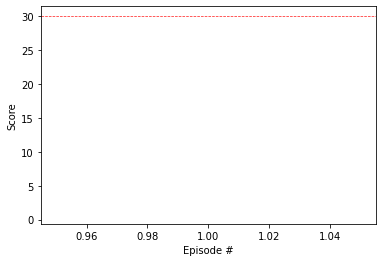

In [10]:
scores = Agent()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(y=30, xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 
#     policies = actor(torch.Tensor(states).to(device))
#     actions = get_action(policies.cpu(), action_size)
#     actions = np.clip(actions, -1, 1)
            
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [11]:
env.close()